In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.svm import SVC

### Data exploration

In [2]:
# Loading dataset
def load_dataset():
    csv_path= os.path.join(path,'diabetes.csv')
    return pd.read_csv(csv_path)

path = "D:\OneDrive - uni-bonn.de\Module 10 Introduction to Machine Learning Tutorial\project_diabetes"
dataset = load_dataset()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [3]:
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
dataset.tail()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


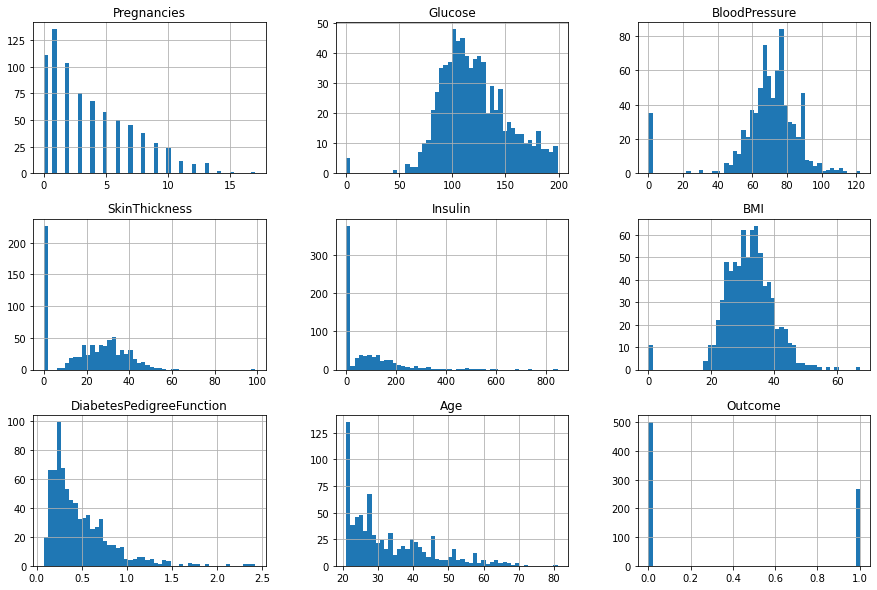

In [5]:
# Plotting dataset
dataset.hist(bins=50, figsize = (15,10))
plt.show()

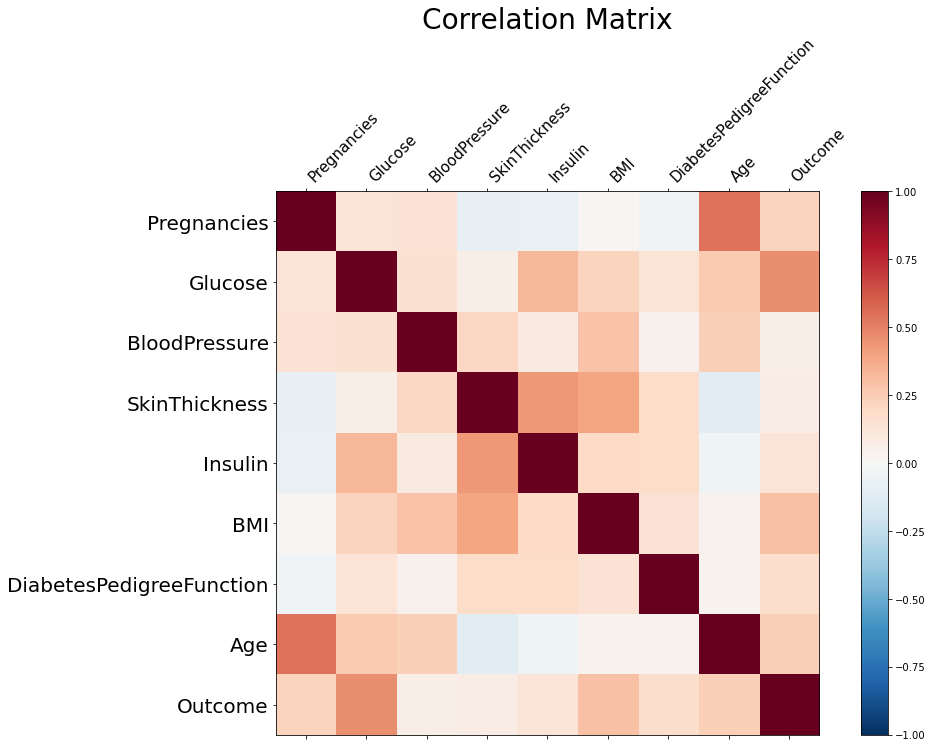

In [6]:
# Exploring correlation
# Correlation matrix: colours the rectangles by correlation value
#%matplotlib inline
fig = plt.figure(figsize=(15, 10))
corr = dataset.corr()

ax = fig.add_subplot(111)
cax = ax.matshow(corr, cmap="RdBu_r", vmin=-1, vmax=1)
fig.colorbar(cax)
plt.xticks(range(len(corr.columns)), corr.columns, fontsize=15, rotation=45, ha='left')
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=20)
plt.title('Correlation Matrix', fontsize=28)
plt.show()

### Preprocessing Data

#### Imputation of missing value

In [7]:
## looking at impausible values
# Imputation with median strategy
imputer = SimpleImputer(missing_values = 0, strategy = 'median')
dataset.iloc[:,1:6] = pd.DataFrame(imputer.fit_transform(dataset.values[:, 1:6]), # ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
                               columns=dataset.columns.values[1:6])

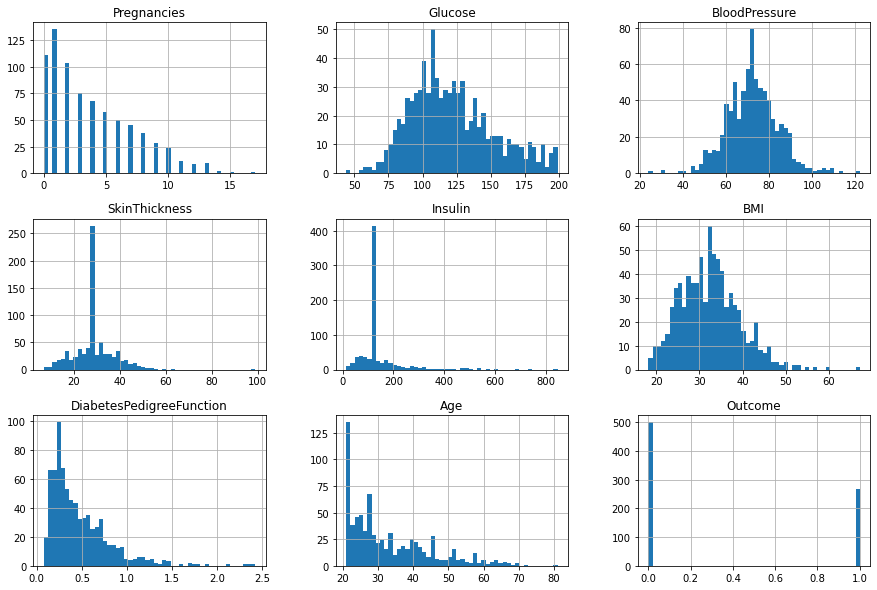

In [8]:
dataset.hist(bins=50, figsize = (15,10))
plt.show()

#### Up-sampling of imbalanced data

In [9]:
# Spliting training set and test set
features = dataset.drop(['Outcome'], axis=1)
labels = dataset['Outcome']
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.25, random_state=123)

In [10]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 576 entries, 269 to 510
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               576 non-null    int64  
 1   Glucose                   576 non-null    float64
 2   BloodPressure             576 non-null    float64
 3   SkinThickness             576 non-null    float64
 4   Insulin                   576 non-null    float64
 5   BMI                       576 non-null    float64
 6   DiabetesPedigreeFunction  576 non-null    float64
 7   Age                       576 non-null    int64  
dtypes: float64(6), int64(2)
memory usage: 40.5 KB


In [11]:
# Check imbalance
# Separate majority and minority classes
df = pd.concat([features_train,labels_train], axis=1)
df.rename(columns={'Outcome':'balance'}, inplace=True)
df_majority = df[df['balance']==0]
df_minority = df[df['balance']==1]

In [12]:
df_majority.balance.value_counts()

0    381
Name: balance, dtype: int64

In [13]:
df_minority.balance.value_counts()

1    195
Name: balance, dtype: int64

In [14]:
# Up-sampling with replacement for minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True, # sample with replacement
                                 n_samples=381, # to match majority class
                                 random_state=123) # reproducible results
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_upsampled.balance.value_counts()

1    381
0    381
Name: balance, dtype: int64

In [15]:
# re-preparing the training sets
features_train = df_upsampled.drop(['balance'], axis=1)
labels_train = df_upsampled[['balance']]
labels_train.rename(columns={'balance':'Outcome'}, inplace=True)

### Fit the model using SVM

In [15]:
# linear kernel
pipe=make_pipeline(StandardScaler(), SelectKBest(f_regression) ,SVC())
params={'selectkbest__k':[1,2,3,4,5,6],
        'svc__kernel' : ['linear'],
        'svc__degree' : [0, 1, 2, 3, 4, 5],
        'svc__C' : [0.1, 1, 10, 100, 1000]}
gs=GridSearchCV(pipe, params, verbose=1, n_jobs=-1, cv=5)
gs_results=gs.fit(features_train, labels_train)
print(f"Best score: {gs_results.best_score_}\nBest parameters: {gs_results.best_params_}")

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best score: 0.7625730994152048
Best parameters: {'selectkbest__k': 6, 'svc__C': 100, 'svc__degree': 0, 'svc__kernel': 'linear'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:   26.5s finished


In [16]:
# rbf kernel
pipe=make_pipeline(StandardScaler(), SelectKBest(f_regression) ,SVC())
params={'selectkbest__k':[1,2,3,4,5,6],
        'svc__kernel' : ['rbf'],
        'svc__gamma' : [0.1, 1, 10, 100],
        'svc__C' : [0.1, 1, 10, 100, 1000]}
gs=GridSearchCV(pipe, params, verbose=1, n_jobs=-1, cv=5)
gs_results=gs.fit(features_train, labels_train)
print(f"Best score: {gs_results.best_score_}\nBest parameters: {gs_results.best_params_}")

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best score: 0.9081355349157206
Best parameters: {'selectkbest__k': 4, 'svc__C': 1, 'svc__gamma': 100, 'svc__kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 509 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 569 out of 600 | elapsed:    3.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    7.5s finished


In [17]:
# sigmoid kernel
pipe=make_pipeline(StandardScaler(), SelectKBest(f_regression) ,SVC())
params={'selectkbest__k':[1,2,3,4,5,6],
        'svc__kernel' : ['sigmoid'],
        'svc__gamma' : [0.1, 1, 10, 100],
        'svc__C' : [0.1, 1, 10, 100, 1000]}
gs=GridSearchCV(pipe, params, verbose=1, n_jobs=-1, cv=5)
gs_results=gs.fit(features_train, labels_train)
print(f"Best score: {gs_results.best_score_}\nBest parameters: {gs_results.best_params_}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 520 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.1s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best score: 0.7481252149982801
Best parameters: {'selectkbest__k': 5, 'svc__C': 0.1, 'svc__gamma': 0.1, 'svc__kernel': 'sigmoid'}


### Evaluation of model

In [18]:
# Implementing SVC with the best hyperparameters
classifier = SVC(kernel="rbf", C=1, gamma=100)
classifier.fit(features_train, labels_train)
pred = classifier.predict(features_test)

Accuracy: 0.62
F1 score: 0.00
AUROC score: 0.50


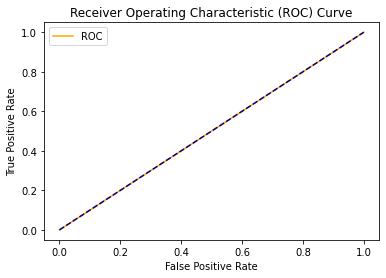

In [19]:
# Defining a function to evaluate metrics
def display_metrics(labels_test, pred):
    #Check accuracy
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(labels_test, pred)
    print('Accuracy: {:.2f}'.format(accuracy))

    # Check F1 score
    from sklearn.metrics import f1_score
    f1 = f1_score(labels_test, pred)
    print ('F1 score: {:.2f}'.format(f1))

    # Check with AUROC
    from sklearn.metrics import roc_auc_score
    auroc = roc_auc_score(labels_test, pred)
    print ('AUROC score: {:.2f}'.format(auroc))
    return accuracy, f1, auroc

# Defining a function to plot the AUROC-curve
def plot_roc_curve(labels_test, pred):
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(labels_test, pred)
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

display_metrics(labels_test, pred)
plot_roc_curve(labels_test, pred)

In [22]:
#Looking up parameters that can be passed to the pipeline
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'selectkbest', 'svc', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])

In [23]:
SVC().get_params().keys()

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

### Comparision between different models

In [16]:
models = {
    'KNN': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(),
    'SVM': SVC()
}

params={'KNN': {'selectkbest__k':[1,2,3,4,5,6],
                'kneighborsclassifier__n_neighbors' : [19],
                'kneighborsclassifier__weights' : ['distance'],
                'kneighborsclassifier__metric' : ['manhattan']
                                 },
        'LogisticRegression': {'selectkbest__k':[1,2,3,4,5,6],
                               'logisticregression__C' : [0.05],
                               'logisticregression__penalty' : ['l1'],
                               'logisticregression__solver' : ['liblinear']
                              },
        'SVM': {'selectkbest__k':[1,2,3,4,5,6],
                'svc__kernel' : ['rbf'],
                'svc__gamma' : [100],
                'svc__C' : [1]}
       }

for name in models.keys():
    est = models[name]
    est_params = params[name]
    pipe = make_pipeline(StandardScaler(),SelectKBest(f_regression) ,est)
    gs = GridSearchCV(pipe, param_grid=est_params, verbose=0, n_jobs=-1, cv=5)
    gs.fit(features_train, labels_train)
    print(f"------{name}------")
    print(f"Best score: {gs.best_score_}")
    print(f"Best parameters are: {gs.best_params_}")


------KNN------
Best score: 0.8426384588923289
Best parameters are: {'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 19, 'kneighborsclassifier__weights': 'distance', 'selectkbest__k': 4}
------LogisticRegression------
Best score: 0.741546267629859
Best parameters are: {'logisticregression__C': 0.05, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear', 'selectkbest__k': 5}
------SVM------
Best score: 0.9081355349157206
Best parameters are: {'selectkbest__k': 4, 'svc__C': 1, 'svc__gamma': 100, 'svc__kernel': 'rbf'}
